# Parte 1

## Instalar librerías

In [1]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy import stats
import statsmodels.api as sms

## Simulación del ejemplo 4 de la PD

![Texto alternativo](https://private-user-images.githubusercontent.com/133716845/491800657-79080098-7da9-4e31-985a-4a2c1ea6c9a7.png?jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3NTkwOTkyODksIm5iZiI6MTc1OTA5ODk4OSwicGF0aCI6Ii8xMzM3MTY4NDUvNDkxODAwNjU3LTc5MDgwMDk4LTdkYTktNGUzMS05ODVhLTRhMmMxZWE2YzlhNy5wbmc_WC1BbXotQWxnb3JpdGhtPUFXUzQtSE1BQy1TSEEyNTYmWC1BbXotQ3JlZGVudGlhbD1BS0lBVkNPRFlMU0E1M1BRSzRaQSUyRjIwMjUwOTI4JTJGdXMtZWFzdC0xJTJGczMlMkZhd3M0X3JlcXVlc3QmWC1BbXotRGF0ZT0yMDI1MDkyOFQyMjM2MjlaJlgtQW16LUV4cGlyZXM9MzAwJlgtQW16LVNpZ25hdHVyZT1jMTc4NTZmYWQ3NjA5YTM2OTcwNDI5ZjA4YWJiMWVhZWVhNzQwN2MzYzUwMzg0OGVjZmY5ZTlhMjY4YTQ3OTA0JlgtQW16LVNpZ25lZEhlYWRlcnM9aG9zdCJ9.J-Znrfn3bqMHFAmwsby2n3PrALcRIhAJiVtaYTlFido )

In [2]:
sample = np.random.uniform(0, 1, (1_000_000, 1)) < 0.001
sample.sum()
sample_indices = np.where(sample)[0]

In [3]:
pop_U1 = np.random.normal(0, 1, (1_000_000, 1))
pop_U2 = np.random.normal(0, 1, (1_000_000, 1))
pop_Z = pop_U1 + pop_U2 + np.random.normal(0, 1, (1_000_000, 1))
pop_X = pop_U1 + np.random.normal(0, 1, (1_000_000, 1))
pop_Y = pop_X + pop_U2 + pop_Z + np.random.normal(0, 1, (1_000_000, 1))

## Regresión controlando y no controlando por Z

In [4]:
print(sms.OLS(pop_Y[sample_indices], pop_X[sample_indices]).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.421
Model:                            OLS   Adj. R-squared (uncentered):              0.420
Method:                 Least Squares   F-statistic:                              715.8
Date:                Sun, 28 Sep 2025   Prob (F-statistic):                   5.45e-119
Time:                        22:32:11   Log-Likelihood:                         -2313.1
No. Observations:                 987   AIC:                                      4628.
Df Residuals:                     986   BIC:                                      4633.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [5]:
print(sms.OLS(pop_Y[sample_indices], np.hstack((pop_X, pop_Z))[sample_indices]).fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.854
Model:                            OLS   Adj. R-squared (uncentered):              0.854
Method:                 Least Squares   F-statistic:                              2888.
Date:                Sun, 28 Sep 2025   Prob (F-statistic):                        0.00
Time:                        22:32:11   Log-Likelihood:                         -1631.8
No. Observations:                 987   AIC:                                      3268.
Df Residuals:                     985   BIC:                                      3277.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Graficar con intervalos de confianza

In [7]:
df = pd.DataFrame({"X": pop_X.flatten(),  "Z": pop_Z.flatten(), "Y": pop_Y.flatten() })
df_sample = df.iloc[sample_indices]
Xmat = sms.add_constant(df_sample[["X", "Z"]])
Y = df_sample["Y"]
model = sms.OLS(Y, Xmat).fit()
b = model.params["X"]
se = model.bse["X"]
tcrit = stats.t.ppf(1 - 0.01/2, df=int(model.df_resid))
lo1, hi1 = b - tcrit*se, b + tcrit*se

In [8]:
Xmat = sms.add_constant(df_sample[["X"]])
Y = df_sample["Y"]
model = sms.OLS(Y, Xmat).fit()
b2 = model.params["X"]
se = model.bse["X"]
tcrit2 = stats.t.ppf(1 - 0.01/2, df=int(model.df_resid))
lo2, hi2 = b2 - tcrit2*se, b2 + tcrit2*se

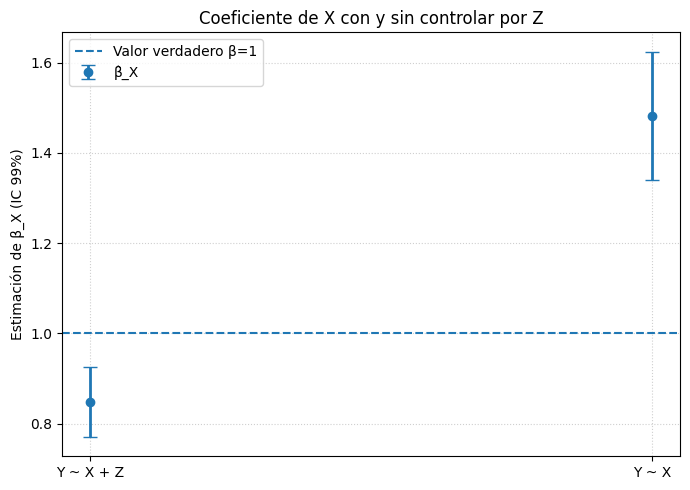

In [9]:
labels = ["Y ~ X + Z", "Y ~ X"]
betas  = np.array([b, b2])
yerr   = np.vstack([betas - np.array([lo1, lo2]),
                    np.array([hi1, hi2]) - betas])

x = np.arange(len(labels))

plt.figure(figsize=(7,5))
plt.errorbar(x, betas, yerr=yerr, fmt="o", capsize=5, linewidth=2, label="β̂_X")
plt.axhline(1.0, linestyle="--", linewidth=1.5, label="Valor verdadero β=1")
plt.xticks(x, labels, rotation=0)
plt.ylabel("Estimación de β_X (IC 99%)")
plt.title("Coeficiente de X con y sin controlar por Z")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Parte 2

## Ahora Z afecta X
## Simulación y DAG

In [10]:
pop_U1 = np.random.normal(0, 1, (1_000_000, 1))
pop_U2 = np.random.normal(0, 1, (1_000_000, 1))
pop_Z = pop_U1 + pop_U2 + np.random.normal(0, 1, (1_000_000, 1))
pop_X = pop_U1 + pop_Z + np.random.normal(0, 1, (1_000_000, 1))
pop_Y = pop_X + pop_U2 + pop_Z + np.random.normal(0, 1, (1_000_000, 1))

In [14]:
pip install causalgraphicalmodels


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from causalgraphicalmodels import CausalGraphicalModel
# Hice un pequeño parche para que ejecutara por mi versión depython
# En c:\Users\PC\.conda\envs\lab2\lib\site-packages\causalgraphicalmodels\cgm.py
# Cambie from collections import Iterable
# Por from collections.abc import Iterable
#Librerias necesarias
import networkx as nx
import matplotlib.pyplot as plt


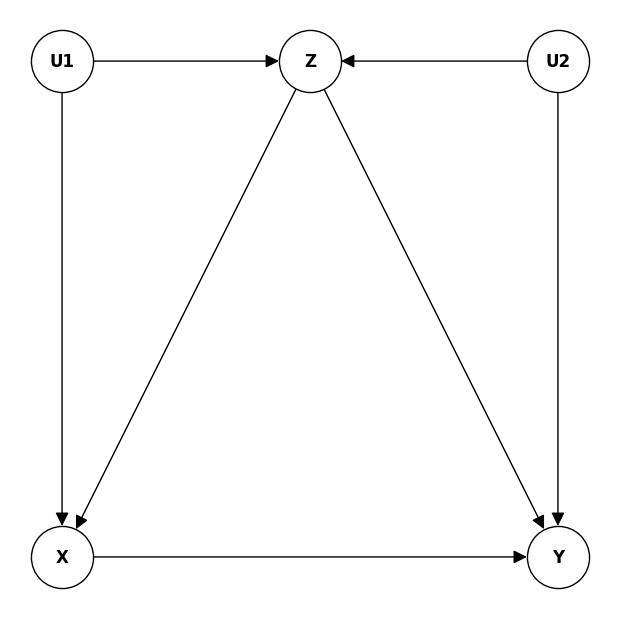

In [30]:
nodes = ["U1", "U2", "X", "Y", "Z"]
edges = [
    ("U1", "Z"),
    ("U1", "X"),
    ("U2", "Z"),
    ("U2", "Y"),
    ("X", "Y"),
    ("Z", "Y"),
    ("Z", "X")  
]
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = {
    "U1": (-1, 1),
    "U2": (1, 1),
    "Z": (0, 1),
    "X": (-1, -0.5),
    "Y": (1, -0.5)
}
plt.figure(figsize=(6,6))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=2000,
    node_color="white",
    edgecolors="black",
    arrowsize=20,
    font_size=12,
    font_weight="bold"
)
plt.show()

## Regresionamos X contra Y usando cada posible combinación

In [ ]:
# Definimos las 8 posibles combinaciones
# 1) Y ~ X
# 2) Y ~ X + Z
# 3) Y ~ X + U1
# 4) Y ~ X + U2
# 5) Y ~ X + Z + U1
# 6) Y ~ X + Z + U2
# 7) Y ~ X + U1 + U2
# 8) Y ~ X + Z + U1 + U2

In [32]:
df = pd.DataFrame({
    "X": pop_X.flatten(),
    "Z": pop_Z.flatten(),
    "U1": pop_U1.flatten(),
    "U2": pop_U2.flatten(),
    "Y": pop_Y.flatten()
})

df_sample = df.iloc[sample_indices]
Parametros = []
ParSe = []
Nombres = []



In [35]:
### 1) Y ~ X
Xmat = sms.add_constant(df_sample[["X"]])
Y = df_sample["Y"]
model = sms.OLS(Y, Xmat).fit()
b2 = model.params["X"]
se = model.bse["X"]
nombre = "Y ~ X"
Parametros.append(b2)
ParSe.append(se)
Nombres.append(nombre)

### 2) Y ~ X + Z
Xmat = sms.add_constant(df_sample[["X", "Z"]])
model = sms.OLS(Y, Xmat).fit()
b2 = model.params["X"]
se = model.bse["X"]
nombre = "Y ~ X + Z"
Parametros.append(b2)
ParSe.append(se)
Nombres.append(nombre)

### 3) Y ~ X + U1
Xmat = sms.add_constant(df_sample[["X", "U1"]])
model = sms.OLS(Y, Xmat).fit()
b2 = model.params["X"]
se = model.bse["X"]
nombre = "Y ~ X + U1"
Parametros.append(b2)
ParSe.append(se)
Nombres.append(nombre)

### 4) Y ~ X + U2
Xmat = sms.add_constant(df_sample[["X", "U2"]])
model = sms.OLS(Y, Xmat).fit()
b2 = model.params["X"]
se = model.bse["X"]
nombre = "Y ~ X + U2"
Parametros.append(b2)
ParSe.append(se)
Nombres.append(nombre)

### 5) Y ~ X + Z + U1
Xmat = sms.add_constant(df_sample[["X", "Z", "U1"]])
model = sms.OLS(Y, Xmat).fit()
b2 = model.params["X"]
se = model.bse["X"]
nombre = "Y ~ X + Z + U1"
Parametros.append(b2)
ParSe.append(se)
Nombres.append(nombre)

### 6) Y ~ X + Z + U2
Xmat = sms.add_constant(df_sample[["X", "Z", "U2"]])
model = sms.OLS(Y, Xmat).fit()
b2 = model.params["X"]
se = model.bse["X"]
nombre = "Y ~ X + Z + U2"
Parametros.append(b2)
ParSe.append(se)
Nombres.append(nombre)

### 7) Y ~ X + U1 + U2
Xmat = sms.add_constant(df_sample[["X", "U1", "U2"]])
model = sms.OLS(Y, Xmat).fit()
b2 = model.params["X"]
se = model.bse["X"]
nombre = "Y ~ X + U1 + U2"
Parametros.append(b2)
ParSe.append(se)
Nombres.append(nombre)

### 8) Y ~ X + Z + U1 + U2
Xmat = sms.add_constant(df_sample[["X", "Z", "U1", "U2"]])
model = sms.OLS(Y, Xmat).fit()
b2 = model.params["X"]
se = model.bse["X"]
nombre = "Y ~ X + Z + U1 + U2"
Parametros.append(b2)
ParSe.append(se)
Nombres.append(nombre)


In [37]:
resultados = pd.DataFrame({"Modelo": Nombres, "Coef_X": Parametros, "SE_X": ParSe})
print(resultados)

                Modelo    Coef_X      SE_X
0                Y ~ X  1.702655  0.022394
1                Y ~ X  1.702655  0.022394
2            Y ~ X + Z  0.784821  0.030337
3           Y ~ X + U1  1.969977  0.031499
4           Y ~ X + U2  1.494676  0.016301
5       Y ~ X + Z + U1  0.976459  0.037028
6       Y ~ X + Z + U2  0.963986  0.025334
7      Y ~ X + U1 + U2  1.485605  0.027701
8  Y ~ X + Z + U1 + U2  0.966585  0.030581


In [39]:
resultados.to_csv("../output/resultados.txt", index=False, sep="\t")

### Based on your findings, in what way(s) can you get a good estimate of the causal effect

#### En el modelo  Y ~ X + Z + U1, se obtiene el mejor resultado (más cercano al valor verdadero que es 1). Aunque el modelo X + Z + U2 o  X + Z + U1 + U2 también presentan valores muy cercanos.

### What is the minimal sufficient set of controls to get a good estimate? [0.5 point]


#### El mínimo para una buena estimación son 3 controles.

### Provide intuition on why you can get good estimates controlling for the variables you stablished above [0.5 point]


#### En este caso tanto U1 como U2 generan backdoor paths que conectan X y Y de manera no causal, por lo que es necesario controlarlos para eliminar las relaciones espurias; además, dado que Z afecta tanto a X como a Y, también actúa como confusor y si no se controla introduce correlación adicional entre ambas variables, de modo que para obtener una buena estimación del efecto de X sobre Y se requiere controlar por Z y al menos uno de los nodos U1 o U2, cerrando así todos los caminos de confusión y logrando que el coeficiente de X refleje principalmente el efecto causal verdadero.